In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import random
%load_ext autoreload
%autoreload 2

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv',index_col=0)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,\
TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,\
Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))
three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
drivingcost_per_mile=0.5
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

56 57 72


In [14]:
car_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>=1)]
car_trips=car_trips.loc[(car_trips.orig_taz !=car_trips.dest_taz) | (car_trips.trip_counter==1)]
car_transit_trips=car_trips.append(traveler_trips[traveler_trips.tripmode>8])
# car_transit_trips=prd.compare_mode_utlity(car_transit_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
random.seed(100)
car_transit_trips_sample=car_transit_trips[car_transit_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]
car_trips_sample=car_trips[car_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]

In [ ]:
for index, group in car_transit_trips.groupby('hh_id'):
    if abs(len(group[group.actual_mode=='Car'])-len(group[group.predicted_mode=='Car']))<10 and len(group)>25:
        print(index,len(group),abs(len(group[group.actual_mode=='Car'])-len(group[group.predicted_mode=='Car'])))

In [155]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=2
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]

route_info2va,darp_solutions2av=\
sod.get_route_info_allhh(car_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1.5
Estimate Route for the  0 th household  2018-07-18 12:28:07.539705
Estimate Route for the  1000 th household  2018-07-18 12:58:51.100316
Estimate Route for the  2000 th household  2018-07-18 13:12:04.774949
Number of AV Trips: 	 21827
Number of Shared Rides: 	 327
Total VMT: 	 160581.2780000041
Number of occupied trips: 	 18057
Number of unoccupied trips: 	 3770
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1554.0033333333445
total_AV_unoccupied_driving_time: 	 255.59166666666633
total_AV_driving_distance: 	 160599.42900000414
total_AV_unoccupied_driving_distance: 	 26749.142999999953


In [196]:
route_info_2avoption,darp_solutions2avoption,hh_car_list=pod.determin_number_car(darp_solutions15,darp_solutions2av,
                    route_info15,route_info2va,30,car_trips_sample)

In [237]:
output_filepath='Output/3000SampleHH/'
dtd.save_run_result('MV2option/',route_info_2avoption,darp_solutions2avoption,output_filepath)


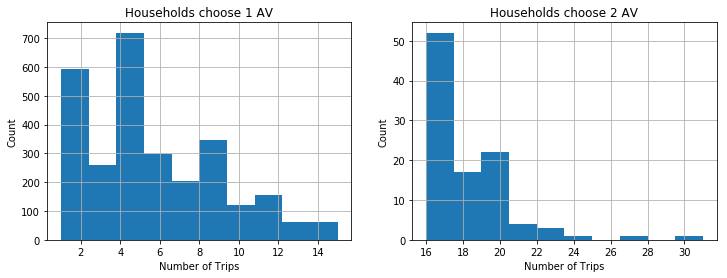

In [228]:
pod.plot_numtrips_numcav_relation(car_trips_sample,hh_car_list)

In [198]:
pod.analysis_network_level_results(route_info_2avoption,darp_solutions2avoption,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22262
Number of Shared Rides: 	 317.0
Total VMT: 	 162213.32200000455
Number of occupied trips: 	 18044
Number of unoccupied trips: 	 4218
Number of transit trips: 	 0.0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1563.466666666677
total_AV_unoccupied_driving_time: 	 265.24333333333254
total_AV_driving_distance: 	 162229.25300000454
total_AV_unoccupied_driving_distance: 	 28434.717999999888
Number of pickup trips: 	 17727.0


In [166]:
pod.analysis_network_level_results(route_info15,darp_solutions15,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22544
Number of Shared Rides: 	 327
Total VMT: 	 164440.83500000494
Number of occupied trips: 	 18054
Number of unoccupied trips: 	 4490
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1585.196666666684
total_AV_unoccupied_driving_time: 	 286.83833333333297
total_AV_driving_distance: 	 164437.4640000048
total_AV_unoccupied_driving_distance: 	 30597.37699999986
Number of pickup trips: 	 17727


In [167]:
pod.analysis_network_level_results(route_info125,darp_solutions125,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22545
Number of Shared Rides: 	 160
Total VMT: 	 165421.28700000534
Number of occupied trips: 	 17887
Number of unoccupied trips: 	 4658
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1598.4633333333506
total_AV_unoccupied_driving_time: 	 298.04666666666617
total_AV_driving_distance: 	 165415.2230000052
total_AV_unoccupied_driving_distance: 	 31763.401999999864
Number of pickup trips: 	 17727


In [168]:
pod.analysis_network_level_results(route_info1,darp_solutions1,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22524
Number of Shared Rides: 	 0
Total VMT: 	 166272.4850000058
Number of occupied trips: 	 17727
Number of unoccupied trips: 	 4797
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1611.8316666666835
total_AV_unoccupied_driving_time: 	 305.7849999999991
total_AV_driving_distance: 	 166272.55500000567
total_AV_unoccupied_driving_distance: 	 32606.173999999843
Number of pickup trips: 	 17727


In [50]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
route_infomodechoice,darp_solutionsmodechoice=\
sod.get_route_info_allhh(car_transit_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )



********************************
1.5
Estimate Route for the  0 th household  2018-07-17 20:35:09.885699
Estimate Route for the  100 th household  2018-07-17 20:36:14.097354
Estimate Route for the  200 th household  2018-07-17 20:37:19.342058
Estimate Route for the  300 th household  2018-07-17 20:38:25.071795
Estimate Route for the  400 th household  2018-07-17 20:39:28.883425
Estimate Route for the  500 th household  2018-07-17 20:40:19.255286
Estimate Route for the  600 th household  2018-07-17 20:41:13.022447
Estimate Route for the  700 th household  2018-07-17 20:41:55.376132
Estimate Route for the  800 th household  2018-07-17 20:42:44.050220
Estimate Route for the  900 th household  2018-07-17 20:43:26.872935
Estimate Route for the  1000 th household  2018-07-17 20:44:05.224370
Estimate Route for the  1100 th household  2018-07-17 20:44:42.103702
Estimate Route for the  1200 th household  2018-07-17 20:45:29.148685
Estimate Route for the  1300 th household  2018-07-17 20:46:07.97

In [59]:
pod.analysis_network_level_results(route_infomodechoice,darp_solutionsmodechoice,car_transit_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips 22404
Number of Shared Rides 310.0
Total VMT 162222.538000003
Number of occupied trips   18081
Number of unoccupied trips  4323
Number of transit trips 1291.0
total_convention_vehicle_driving_time 1311.3933333333218
total_convention_vehicle_driving_distance 134187.67900000012
total_AV_driving_time 1559.418333333341
total_AV_unoccupied_driving_time 286.98333333333375
total_AV_driving_distance 162270.12600000302
total_AV_unoccupied_driving_distance 30273.89699999995


In [69]:
more=0
less=0
for hh_id, group in car_transit_trips_sample.groupby('hh_id'):
    if len(group[group.tripmode<=6])<darp_solutionsmodechoice[hh_id]['num_pickup_trips']:
        more+=1
        print(hh_id)
    elif len(group[group.tripmode<=6])>darp_solutionsmodechoice[hh_id]['num_pickup_trips']:
        less+=1

15810
15851
72538
72768
72823
151761
152814
202532
241449
242157
242311
297487
297498
297504
297562
297571
298122
298125
298263
337525
364651
364683
365212
365243
365367
409870
435748
483941
483976
484582
484691
555242
583527
583533
583621
584795
584910
644711
646726
647200
724473
724477
725207
725336
763728
763740
764963
811446
811803
831192
831240
831304
831907
831915
832009
832024
867810
867813
867865
867903
869077
869268
869274
869278
916806
971955
971965
971987
972003
972045
972075
972793
972797
1041988
1042002
1042028
1042059
1042248
1043702
1113250
1113688
1113696
1113770
1113918
1114172
1119462
1120020
1120052
1120176
1120184
1120550
1120561
1120642
1120678
1120698
1257225
1257295
1265751
1265826
1265834
1266631
1266722
1266723
1266868
1309359
1309394
1309397
1309411
1309480
1309537
1309630
1309650
1309654
1309725
1309862
1309887
1309933
1309948
1310076
1312599
1312779
1312787
1313052
1313083
1313094
1313101
1313253
1313296
1313297
1313302
1313305
1313314
1400557
1400606
140164

In [67]:
less

621

In [63]:
len(route_info[(route_info.transit_utility<route_info.car_utility)& (route_info.transit_utility!=0)])

0

In [58]:
route_infomodechoice.pickup_trip_flag.sum()

17765.0

In [ ]:
len(car_trips_sa)

In [57]:
for hh_id,group in car_transit_trips_sample.groupby('hh_id'):
    if darp_solutionsmodechoice[hh_id]['route_info'].pickup_trip_flag.sum()<len(group):
        print(hh_id)

16296
72716
72768
72797
72843
73989
74271
151808
151820
152605
152788
152790
152814
241382
241449
242376
297504
297517
297562
297571
298241
298244
298263
326314
409302
409304
409902
435743
435763
450308
484028
484691
527616
555242
555252
563592
563791
563837
563874
583588
583641
583662
584802
584804
584811
584910
584932
644330
644363
644498
644523
644596
644654
644739
644740
644762
646694
647135
647142
647200
647311
647352
647361
712930
724514
724551
725333
763740
763747
763755
763761
764982
765129
765145
765148
765274
811446
811802
831240
831963
831970
831977
832024
867813
867859
867902
867911
867924
867936
867937
867952
869032
869046
869265
869268
869274
869276
916802
971989
972045
972075
972087
972102
972111
972119
972793
972797
972800
972815
972820
972827
972938
972945
973021
1011994
1011995
1011996
1012008
1012050
1012063
1012604
1027956
1028116
1028171
1042209
1042220
1042271
1042272
1042283
1043648
1043677
1043681
1043713
1043721
1043722
1043836
1113250
1113305
1113349
1113654
1

In [43]:
route_info.columns

Index(['orig_zone', 'dest_zone', 'orig_node_index', 'dest_node_index',
       'person_id', 'origin_arrival_time', 'dest_arrival_time',
       'dest_expected_arrival_time', 'value_of_time', 'start_time',
       'Activity_Time', 'hh_id', 'hh_vehicle_id', 'shared_ride_flag',
       'pickup_trip_flag', 'transit_utility', 'car_utility',
       'intrasuperzone_flag', 'seg_index', 'veh_seg_index'],
      dtype='object')

Number of Trips 21827
Number of Shared Rides 327
Total VMT 160581.2780000041
Number of occupied trips   18057
Number of unoccupied trips  3770
Number of transit trips 0
total_convention_vehicle_driving_time 1310.4933333333283
total_convention_vehicle_driving_distance 133666.38099999996
total_AV_driving_time 1554.0033333333445
total_AV_unoccupied_driving_time 255.59166666666633
total_AV_driving_distance 160599.42900000414
total_AV_unoccupied_driving_distance 26749.142999999953


In [28]:
route_info.pickup_trip_flag.sum()

17727

In [29]:
route_info.shared_ride_flag.sum()

327

In [ ]:
route_info.

In [ ]:
len(route_info_modechoice)

In [ ]:
len(car_transit_trips_sample)

In [ ]:
len(route_info_modechoice)

In [ ]:
total_num_pickup_trip=0
for keys,value in darp_solutions_modechoice.items():
#     print(value)
    total_num_pickup_trip+=value['num_pickup_trips']


In [ ]:
total_num_pickup_trip

In [ ]:
target_trips.groupby('predicted_mode').count()

In [ ]:
route_info_modechoice08.to_csv('route_info_modechoice08')


In [ ]:
pod.save_obj(darp_solutions_modechoice08,'darp_solutions_modechoice08','Output/')

In [ ]:
pickle.dump(darp_solutions_modechoice08,'darp_solutions_modechoice09',)

In [ ]:
len(route_info_modechoice08[route_info_modechoice08.person_id==0])

In [ ]:
drivingcost_per_mile=0.5

In [ ]:
modechoice_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
modechoice_target_trips=modechoice_target_trips[(modechoice_target_trips.orig_taz!=modechoice_target_trips.dest_taz) | (modechoice_target_trips.trip_counter==1)]
modechoice_target_trips=modechoice_target_trips.append(traveler_trips[traveler_trips.tripmode>8])

In [ ]:
modechoice_target_trips=prd.compare_mode_utlity(modechoice_target_trips,TransitMazTazFlag,
                                               three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                                               Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                                               Vehicular_Skim_Dict1,superzone_map,drivingcost_per_mile,transit_zone_dict)

In [ ]:
modechoice_target_trips.value_of_time=modechoice_target_trips.value_of_time*0.8

In [ ]:
modechoice_target_trips['car_utility']=modechoice_target_trips.apply(lambda row: 
        (prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
        Vehicular_Skim_Dict,0,superzone_map,drivingcost_per_mile)), axis=1)
    
modechoice_target_trips['predicted_mode']=modechoice_target_trips.apply(lambda row:
    'NonCar' if row.transit_utility<row.car_utility else 'Car',axis=1)

In [ ]:
modechoice_target_trips.groupby(['predicted_mode']).count()

In [ ]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
route_info_allcar=pd.read_csv(output_filepath+'route_info.csv')
darp_solution=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='50'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar,darp_solution,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

In [ ]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
route_info_allcar15=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_callcar15=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='50'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar15,darp_solution_callcar15,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

In [ ]:
run_name='allhhcartrip1.25/'
output_filepath='Output/'+run_name
route_info_allcar125=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_allcar125=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='50'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar,darp_solution_allcar125,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

In [ ]:
run_name='modechoice1.1/'
output_filepath='Output/'+run_name
route_info_modechoice10=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_modechoice10=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath
external_factor='40'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_modechoice10,darp_solution_modechoice10,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

# dtd.route_to_vehiclepathdat(route_info_modechoice10,origin_links,output_filepath,
#                             vehicle_filepath,path_filepath,superzone_map,
#                                 intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
community_solution_allcar15=pod.load_obj('community_allcar15','Output/')

In [ ]:
community_solution_allcar15

In [ ]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
community_hh_list=[972044,972024,2212041,2212030,937968,2285653,1309779,1738127,2034377,2066988]
community_trips=pd.DataFrame()
for hh_id in community_hh_list:
#     print(len(target_trips[target_trips.hh_id==hh_id]))
    community_trips=community_trips.append(target_trips[target_trips.hh_id==hh_id])
sorted_trips=community_trips.sort_values('starttime')
pod.analysis_one_hh_result(937968,[community_solution_allcar15],community_trips,5,Vehicular_Skim_Dict,superzone_map)

In [ ]:
pod.plot_route_info_schedule(community_solution_allcar15['route_info'],community_trips,5)